In [1]:
import os, torch
os.chdir("/Users/ESKO/PYWORK/NHITS")
print(os.getcwd())

C:\Users\ESKO\anaconda3\envs\dl\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


C:\Users\ESKO\PYWORK\NHITS


In [2]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from ray import tune
from sklearn.preprocessing import StandardScaler

from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoTFT
from neuralforecast.models import NBEATS, NBEATSx, NHITS, TFT
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, GMM, PMM
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.losses.pytorch import MAE

## <기준날짜 및 예측 기간 설정>

In [239]:
cutoff_date = '2022-12-31' ## len = 65
test_period = 12  ## 예측 기간 (월)
corr_rate = 0.8 ## Lag corr rate
future_variable_limit = 10

## <원 data set>

In [161]:
df = pd.read_csv('./data/metal_pst.csv')
df.rename(columns={'date':'ds'},inplace=True)
df.rename(columns={'li2co3_cif_fast_kg_spot_exchng':'y'},inplace=True)
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d')

raw_y_set_resampled = df.copy()
raw_y_set_resampled.rename(columns={'ds':'date'},inplace=True)
raw_y_set_resampled.rename(columns={'lioh_cif_fast_kg_spot_exchng':'y2'},inplace=True)
del raw_y_set_resampled['unique_id']

## Feature shift

In [5]:
%%time

raw_y_set_resampled = raw_y_set_resampled[raw_y_set_resampled.date<=cutoff_date]
raw_y_set_shifted_merged = raw_y_set_resampled['date']

for i in range(len(raw_y_set_resampled.columns)):
    if i == len(raw_y_set_resampled.columns) - 1:
        break
    raw_y_set_shifted = raw_y_set_resampled.iloc[:,[0,i+1]].dropna()
    for j in range(test_period-1,test_period):
        raw_y_set_shifted = pd.concat([raw_y_set_shifted, (raw_y_set_shifted.iloc[:,1].shift(j+1).rename(raw_y_set_resampled.columns[i+1] + '_' +str(j+1)))],axis=1)
        raw_y_set_shifted_merged = pd.merge(raw_y_set_shifted_merged, raw_y_set_shifted, how= 'outer') 
        if j == len(raw_y_set_shifted.iloc[:,1]) -2 :
            break
# raw_y_set_shifted_merged.to_csv('./data/raw_y_set_shifted_merged.csv', encoding='cp949')

CPU times: total: 11 s
Wall time: 26 s


In [6]:
raw_y_set_shifted_merged

,date,y,y_7,y2,y2_7,Baltic Dry Index (BDI),Baltic Dry Index (BDI)_7,Howe Robinson Container Index,Howe Robinson Container Index_7,Shanghai Containerized Freight Index (SCFI),...,Allkem Limited (AKE.AX)_price_Open,Allkem Limited (AKE.AX)_price_Open_7,Allkem Limited (AKE.AX)_price_High,Allkem Limited (AKE.AX)_price_High_7,Allkem Limited (AKE.AX)_price_Low,Allkem Limited (AKE.AX)_price_Low_7,Allkem Limited (AKE.AX)_price_Close,Allkem Limited (AKE.AX)_price_Close_7,Allkem Limited (AKE.AX)_price_Adj Close,Allkem Limited (AKE.AX)_price_Adj Close_7
0,2016-01-31,20.177268,NaN,20.680110,NaN,386.300000,NaN,449.750000,NaN,1051.760000,...,2.408986,NaN,2.484987,NaN,2.331150,NaN,2.432048,NaN,2.432048,NaN
1,2016-02-29,23.306868,NaN,24.462716,NaN,306.904762,NaN,447.750000,NaN,1066.213333,...,2.428055,NaN,2.472632,NaN,2.373518,NaN,2.408611,NaN,2.408611,NaN
2,2016-03-31,25.223010,NaN,28.364874,NaN,383.333333,NaN,449.000000,NaN,868.470000,...,2.680345,NaN,2.744366,NaN,2.611581,NaN,2.677025,NaN,2.677025,NaN
3,2016-04-30,25.308243,NaN,29.181978,NaN,607.476191,NaN,443.000000,NaN,748.392000,...,3.146489,NaN,3.210972,NaN,3.066818,NaN,3.118106,NaN,3.118106,NaN
4,2016-05-31,24.875099,NaN,27.810405,NaN,619.900000,NaN,447.000000,NaN,731.347500,...,3.784351,NaN,3.882355,NaN,3.701965,NaN,3.795215,NaN,3.795215,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,2021-12-31,33.043478,12.727273,31.521739,13.147727,2832.111111,2965.263158,4509.000000,2147.500000,2455.538000,...,9.318571,6.549524,9.517619,6.685714,9.130952,6.385714,9.347143,6.538095,9.347143,6.538095
72,2022-01-31,43.260870,13.340909,38.652174,14.329545,1760.800000,2932.000000,4743.750000,2568.800000,2871.495000,...,10.718947,6.393333,10.927368,6.519524,10.405789,6.271905,10.625263,6.379048,10.625263,6.379048
73,2022-02-28,56.425000,14.045455,51.862500,15.465909,1834.900000,3187.954545,5252.250000,3357.333333,2840.395000,...,9.265000,7.128636,9.474000,7.297500,9.046250,7.026591,9.249500,7.171818,9.249500,7.171818
74,2022-03-31,71.086957,14.590909,69.576087,16.000000,2464.086957,3720.000000,5771.000000,4260.500000,2628.505000,...,10.260870,8.985455,10.461304,9.192500,10.055217,8.762500,10.266087,8.986818,10.266087,8.986818


#### 해당 기간에서의 lag corr best

In [7]:
raw_y_set_shifted_merged_corr = raw_y_set_shifted_merged.corr()
raw_y_set_shifted_merged_filtered = raw_y_set_shifted_merged_corr[raw_y_set_resampled.columns.drop('date')]
raw_y_set_shifted_merged_filtered = raw_y_set_shifted_merged_filtered.loc[raw_y_set_shifted_merged_filtered.index != 'y']
raw_y_set_shifted_merged_filtered = raw_y_set_shifted_merged_filtered.loc[raw_y_set_shifted_merged_filtered.index != 'y2']
raw_y_set_shifted_merged_filtered_y = raw_y_set_shifted_merged_filtered.iloc[:,:1]
raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_y[raw_y_set_shifted_merged_filtered_y.y >= corr_rate]
raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_upto_corr_rate[raw_y_set_shifted_merged_filtered_upto_corr_rate.index.str.contains(f'_{test_period}')]
raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_upto_corr_rate.sort_values('y',ascending=False)

if len(raw_y_set_shifted_merged_filtered_upto_corr_rate) >= 20:
    raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_upto_corr_rate[:future_variable_limit]
else:
    pass

futr_list = raw_y_set_shifted_merged_filtered_upto_corr_rate.index.values.tolist()
futr_list = [word.replace(f"_{test_period}", "") for word in futr_list]

if 'y2' in futr_list:
    (futr_list).remove('y2')
else:
    pass

if 'li2co395_am_kg' in futr_list:
    (futr_list).remove('li2co395_am_kg')
else:
    pass

if 'mn_mb_kg' in futr_list:
    (futr_list).remove('mn_mb_kg')
else:
    pass

#### 해당 기간에서의 corr best

In [28]:
futr_list

['Howe Robinson Container Index',
 '소맥 Durum [미국(생산자 가격)] 현물',
 '002466.SZ(Tianqi Lithium)_price_High',
 '002466.SZ(Tianqi Lithium)_price_Adj Close',
 '002466.SZ(Tianqi Lithium)_price_Close',
 '002466.SZ(Tianqi Lithium)_price_Open',
 '002466.SZ(Tianqi Lithium)_price_Low',
 'al_lme_kg',
 'Pilbara Mineral Limited_price_Adj Close',
 'Pilbara Mineral Limited_price_Close',
 'Pilbara Mineral Limited_price_High',
 'Pilbara Mineral Limited_price_Open',
 'Pilbara Mineral Limited_price_Low',
 '커피 Arabicas [미국/유럽] 현물',
 'ALB_price_Low',
 'ALB_price_Close',
 'ALB_price_High',
 'ALB_price_Open']

In [9]:
hist_var_chcek = raw_y_set_resampled.iloc[:,1:]

hist_var_corr = hist_var_chcek.corr()
hist_var_corr_filtered = hist_var_corr.loc[hist_var_corr.index != 'y']
hist_var_corr_filtered = hist_var_corr_filtered.loc[hist_var_corr_filtered.index != 'y2']
hist_var_corr_filtered_y = hist_var_corr_filtered.iloc[:,:1]
hist_var_corr_filtered_y_corr_rate = hist_var_corr_filtered_y[hist_var_corr_filtered_y.y >= corr_rate]
hist_var_corr_filtered_y_only = hist_var_corr_filtered_y_corr_rate[hist_var_corr_filtered_y_corr_rate.index.str.contains('li2co3')==False]
hist_var_corr_filtered_y_only = hist_var_corr_filtered_y_only[hist_var_corr_filtered_y_only.index.str.contains('lioh')==False]
hist_var_corr_filtered_y_only = hist_var_corr_filtered_y_only.sort_values('y',ascending=False)
hist_var_list = hist_var_corr_filtered_y_only.index.values.tolist()

hist_var_list

['CPI_PRT_TOT_FOODENRG_AGRWTH',
 '대두 [미국(생산자 가격)] 현물',
 'CPI_BEL_TOT_AGRWTH',
 '중국 니켈 SEMIS 수입량',
 'CPI_PRT_TOT_AGRWTH',
 'CPI_GBR_TOT_FOODENRG_AGRWTH',
 'CPI_TUR_ENRG_AGRWTH',
 '대두유 crude and refined average price [파라나구아(FOB)] 현물',
 'CPI_LTU_TOT_AGRWTH',
 'CPI_GRC_TOT_AGRWTH',
 'CPI_DNK_ENRG_IDX2015',
 'al_lme_kg',
 'CPI_BEL_ENRG_AGRWTH',
 'CPI_OECD_TOT_FOODENRG_AGRWTH',
 'PPP_POL',
 'CPI_BEL_TOT_FOODENRG_AGRWTH',
 'CPI_GRC_ENRG_IDX2015',
 'CPI_KOR_TOT_FOODENRG_AGRWTH',
 'CPI_LTU_FOOD_AGRWTH',
 'CPI_NLD_ENRG_AGRWTH',
 'CPI_EST_TOT_FOODENRG_AGRWTH',
 'CPI_GRC_ENRG_AGRWTH',
 'CPI_DNK_TOT_AGRWTH',
 'Pilbara Mineral Limited_price_Adj Close',
 'HOUSECOST_KOR',
 'CPI_EST_TOT_AGRWTH',
 'CPI_GBR_TOT_AGRWTH',
 'CPI_ITA_TOT_AGRWTH',
 'CPI_ESP_TOT_FOODENRG_AGRWTH',
 'CPI_CHL_TOT_AGRWTH',
 'CPI_SWE_TOT_AGRWTH']

## scaler

In [10]:
# df_tgt = df.iloc[:,3:]

# scaler = StandardScaler()
# scaler.fit(df_tgt)
# arr = scaler.transform(df_tgt)
# df_tmp = pd.DataFrame(arr, columns=df_tgt.columns)
# df = pd.concat([df.iloc[:,:3],df_tmp], axis=1)

#### static DF

In [11]:
static_df = pd.read_csv('/users/ESKO/PYWORK/NHITS/data/static_df.csv')

## <Training & Test>

#### 날짜 확인

In [12]:
# train = df.loc[df.ds < '2021-06-30']
# test = df.loc[df.ds > '2021-06-30']

#### 날짜 별 len 확인

In [13]:
# len(df.loc[df.ds<'2021-06-30'])

In [14]:
# len(Y_train_df)
# len(Y_test_df)
# len(df)

Test 용 DF 및 선행 변수 반영

In [240]:
future_date_series = pd.date_range(pd.date_range(cutoff_date,periods=2,freq='M')[1],periods=test_period,freq='M')
future_date = pd.DataFrame(future_date_series,columns=['ds'])
# future_date['unique_id'] = 'A'
future_df_temp = pd.concat([raw_y_set_resampled.rename(columns={'date':'ds'}).iloc[-(test_period+len(Y_test_df)):,:],future_date])
future_df_temp[futr_list] = future_df_temp[futr_list].shift(test_period)

future_df_with_index = list(['ds','unique_id']) + futr_list
future_df_with_index

future_df_temp = future_df_temp[future_df_temp.columns[future_df_temp.columns.isin(future_df_with_index)]].reset_index(drop=True)
future_df_temp.insert(1, 'unique_id', 'A')
future_df = future_df_temp.iloc[-test_period:,:].reset_index(drop=True)
future_df

,ds,unique_id,Howe Robinson Container Index,소맥 Durum [미국(생산자 가격)] 현물,커피 Arabicas [미국/유럽] 현물,al_lme_kg,ALB_price_Open,ALB_price_High,ALB_price_Low,ALB_price_Close,002466.SZ(Tianqi Lithium)_price_Open,002466.SZ(Tianqi Lithium)_price_High,002466.SZ(Tianqi Lithium)_price_Low,002466.SZ(Tianqi Lithium)_price_Close,002466.SZ(Tianqi Lithium)_price_Adj Close,Pilbara Mineral Limited_price_Open,Pilbara Mineral Limited_price_High,Pilbara Mineral Limited_price_Low,Pilbara Mineral Limited_price_Close,Pilbara Mineral Limited_price_Adj Close
0,2023-01-31,A,4743.750000,1490.0,233.704286,3.003075,225.309001,230.116499,219.495000,224.662000,91.567895,93.538947,88.254737,90.427368,98.293572,3.529474,3.615526,3.433947,3.531579,3.531579
1,2023-02-28,A,5252.250000,1590.0,245.044500,3.260825,214.396842,220.505265,209.543684,214.544209,90.809375,93.057500,88.329375,91.121875,98.293572,3.086500,3.168250,3.005750,3.071000,3.071000
2,2023-03-31,A,5771.000000,1530.0,222.514348,3.537848,195.943043,200.680000,191.846956,196.760434,86.335000,88.068929,83.460000,85.713214,83.591667,2.928696,2.984565,2.867391,2.915217,2.915217
3,2023-04-30,A,5680.666667,1550.0,226.235000,3.256579,209.736501,212.995000,204.032002,207.821000,72.054211,74.201053,70.164737,72.151053,72.151053,3.061667,3.116111,2.971111,3.025556,3.430000
4,2023-05-31,A,5590.333333,1430.0,217.776364,2.826357,230.712380,237.299524,223.879523,231.825239,87.164737,90.227895,85.612632,88.267895,88.267895,2.732273,2.790000,2.663182,2.725909,3.430000
5,2023-06-30,A,5613.200000,1200.0,230.394545,2.562925,229.314763,234.156666,223.592381,228.886666,112.868571,116.548571,110.617619,114.330476,114.330476,2.267143,2.324762,2.178810,2.242381,3.430000
6,2023-07-31,A,5488.500000,1270.0,214.802857,2.401571,211.374000,214.909000,207.643500,212.568501,128.020952,131.576667,124.470952,127.828095,127.828095,2.409048,2.462143,2.366429,2.416190,3.430000
7,2023-08-31,A,4966.000000,1080.0,221.901304,2.431318,266.012173,272.024783,261.699566,266.892608,116.026429,118.736429,113.260000,115.947857,115.947857,3.106087,3.192391,3.055435,3.146957,3.430000
8,2023-09-30,A,3445.000000,992.0,219.593182,2.229909,279.183812,286.019996,273.256665,280.213810,116.026429,118.736429,113.260000,115.947857,115.947857,3.003048,3.059238,2.909762,2.981429,2.981429
9,2023-10-31,A,1836.250000,1020.0,192.267619,2.243286,268.260478,273.577618,261.014763,268.654763,116.026429,118.736429,113.260000,115.947857,115.947857,3.229143,3.311762,3.153143,3.237571,3.237571


In [73]:
future_df = pd.concat([future_df[['ds','unique_id']],future_df[futr_list]])

In [15]:
Y_train_df = df[df.ds<=cutoff_date]
Y_test_df = df[df.ds>cutoff_date]

if len(Y_test_df) > 12:    
    Y_test_df = Y_test_df[:12]
else:
    pass
# Y_train_df = df[df.ds<df['ds'].values[len(df.loc[df.ds<=cutoff_date])]]
# Y_test_df = df[df.ds>=df['ds'].values[len(df.loc[df.ds<=cutoff_date])]]

In [16]:
futr_temp = Y_test_df.drop(['y'], axis=1).copy()
# futr_list = [
#              'Shanghai Containerized Freight Index (SCFI)',
#              '대두 [미국(생산자 가격)] 현물',
#              # '대두유 crude and refined average price [파라나구아(FOB)] 현물',
#              '보일러용 후판 Q245R 30mm Xinyu Steel [중국] 현물',
#              # 'HOUSECOST_KOR'
#              ]
futr_date = futr_temp.iloc[:,:2].copy()
futr_df = pd.concat([futr_date, futr_temp[futr_list]], axis=1)

# futr_df

#### No 변수

In [17]:
# horizon = len(Y_test_df)

# models = [
#           # NBEATS(input_size=5 * horizon, gpus = 1, h=horizon, max_epochs=100),
#           # NBEATSx(h=12, input_size=24,
#           #       # loss=DistributionLoss(distribution='Normal', level=[80, 90]),
#           #       gpus=1,
#           #       scaler_type='robust',
#           #       stat_exog_list = None,  
#           #       futr_exog_list = futr_list,
#           #       max_steps=100,
#           #       # val_check_steps=10,
#           #       # early_stop_patience_steps=2
#           #      ),
#           NHITS(input_size=5 * horizon, 
#                 h=horizon+1,
#                 gpus = 1,
#                 stat_exog_list = None,
#                 hist_exog_list=None,
#                 futr_exog_list = None,
#                 # futr_exog_list = futr_list,
#                 # n_freq_downsample=[24, 12, 1],
#                 # mlp_units = [[512, 512], [512, 512], [512, 512]],
#                 # n_pool_kernel_size = [2, 2, 1],
#                 # n_freq_downsample=[24, 12, 1],
#                 scaler_type = 'standard',
#                 learning_rate=1e-4,
#                 pooling_mode = 'MaxPool1d',
#                 activation='ReLU',
#                 batch_size=128,
#                 random_seed=42,
#                 max_epochs=200
#                ),
#            # NHITS(
#            #       h,
#            #       input_size,
#            #       futr_exog_list=None,
#            #       hist_exog_list=None,
#            #       stat_exog_list=None,
#            #       stack_types: list = ['identity', 'identity', 'identity'],
#            #       n_blocks: list = [1, 1, 1],
#            #       mlp_units: list = [[512, 512], [512, 512], [512, 512]],
#            #       n_pool_kernel_size: list = [2, 2, 1],
#            #       n_freq_downsample: list = [4, 2, 1],
#            #       pooling_mode: str = 'MaxPool1d',
#            #       interpolation_mode: str = 'linear',
#            #       dropout_prob_theta=0.0,
#            #       activation='ReLU',
#            #       loss=MAE(),
#            #       learning_rate=0.001,
#            #       batch_size=32,
#            #       windows_batch_size: int = 1024,
#            #       step_size: int = 1,
#            #       scaler_type='identity',
#            #       random_seed=1,
#            #       num_workers_loader=0,
#            #       drop_last_loader=False,
#            #       **trainer_kwargs,
    
#           # TFT(h=12, 
#           #     input_size=5 * horizon,
#           #     # hidden_size=20,
#           #     #loss=DistributionLoss(distribution='Poisson', level=[80, 90]),
#           #     #loss=DistributionLoss(distribution='Normal', level=[80, 90]),
#           #     #loss=DistributionLoss(distribution='StudentT', level=[80, 90]),
#           #     learning_rate=0.005,
#           #     stat_exog_list = None,
#           #     futr_exog_list = futr_list,
#           #     max_steps=100,
#           #     gpus=1,
#           #     # val_check_steps=10,
#           #     # early_stop_patience_steps=10,
#           #     scaler_type='robust',
#           #     # windows_batch_size=None,
#           #     enable_progress_bar=True),
#              ]
# nforecast_nv = NeuralForecast(models=models, freq='M')
# nforecast_nv.fit(df=Y_train_df)
# Y_hat_df_nv = nforecast_nv.predict(futr_df=futr_df).reset_index()

In [18]:
# # Plot predictions
# fig, ax = plt.subplots(1, 1, figsize = (20, 7))
# Y_hat_df_nv = Y_test_df.merge(Y_hat_df_nv, how='left', on=['unique_id', 'ds'])
# plot_df_nv = pd.concat([Y_train_df, Y_hat_df_nv]).set_index('ds')

# plot_df_nv[['y', 'NHITS']].plot(ax=ax, linewidth=2, marker='o')
# plt.axvline(cutoff_date, color='red')

# ax.set_title(f'LI2CO3 Actual and Predicted Plot - Cutoff: {cutoff_date}', fontsize=22)
# ax.set_ylabel('LI2CO3_PRICE', fontsize=20)
# ax.set_xlabel('Date', fontsize=20)
# ax.legend(prop={'size': 15})
# ax.grid()

# fig.savefig(f'./data/forecast_plot_{cutoff_date}_nv.png')

In [19]:
# plot_df_nv[['y', 'NHITS']].to_csv(f'./data/forecasting_{cutoff_date}_nv.csv',index=False)

#### Yes 변수

In [24]:
horizon = len(Y_test_df)

models = [
          # NBEATS(input_size=5 * horizon, gpus = 1, h=horizon, max_epochs=100),
          # NBEATSx(h=12, input_size=24,
          #       # loss=DistributionLoss(distribution='Normal', level=[80, 90]),
          #       gpus=1,
          #       scaler_type='robust',
          #       stat_exog_list = None,  
          #       futr_exog_list = futr_list,
          #       max_steps=100,
          #       # val_check_steps=10,
          #       # early_stop_patience_steps=2
          #      ),
          NHITS(input_size=5 * horizon, 
                h=horizon,
                gpus = 1,
                # stat_exog_list = None,
                # hist_exog_list=hist_var_list,
                # futr_exog_list = futr_list,
                # n_blocks = [1, 1, 1],
                mlp_units = [[512, 512], [512, 512], [512, 512]],
                n_pool_kernel_size = [2, 2, 1],
                # n_freq_downsample=[24, 12, 1],
                scaler_type = 'standard',
                learning_rate=1e-4,
                pooling_mode = 'MaxPool1d',
                activation='ReLU',
                batch_size=128,
                random_seed=42,
                max_epochs=100
               ),
           # NHITS(
           #       h,
           #       input_size,
           #       futr_exog_list=None,
           #       hist_exog_list=None,
           #       stat_exog_list=None,
           #       stack_types: list = ['identity', 'identity', 'identity'],
           #       n_blocks: list = [1, 1, 1],
           #       mlp_units: list = [[512, 512], [512, 512], [512, 512]],
           #       n_pool_kernel_size: list = [2, 2, 1],
           #       n_freq_downsample: list = [4, 2, 1],
           #       pooling_mode: str = 'MaxPool1d',
           #       interpolation_mode: str = 'linear',
           #       dropout_prob_theta=0.0,
           #       activation='ReLU',
           #       loss=MAE(),
           #       learning_rate=0.001,
           #       batch_size=32,
           #       windows_batch_size: int = 1024,
           #       step_size: int = 1,
           #       scaler_type='identity',
           #       random_seed=1,
           #       num_workers_loader=0,
           #       drop_last_loader=False,
           #       **trainer_kwargs,
    
          # TFT(h=12, 
          #     input_size=5 * horizon,
          #     # hidden_size=20,
          #     #loss=DistributionLoss(distribution='Poisson', level=[80, 90]),
          #     #loss=DistributionLoss(distribution='Normal', level=[80, 90]),
          #     #loss=DistributionLoss(distribution='StudentT', level=[80, 90]),
          #     learning_rate=0.005,
          #     stat_exog_list = None,
          #     futr_exog_list = futr_list,
          #     max_steps=100,
          #     gpus=1,
          #     # val_check_steps=10,
          #     # early_stop_patience_steps=10,
          #     scaler_type='robust',
          #     # windows_batch_size=None,
          #     enable_progress_bar=True),
             ]
nforecast = NeuralForecast(models=models, freq='M')
nforecast.fit(df=Y_train_df)
Y_hat_df = nforecast.predict(futr_df=futr_df).reset_index()

Epoch 0:  50%|██████████████▌              | 1/2 [00:00<00:00,  2.06it/s, loss=1.66, v_num=1510, train_loss_step=1.660]
Validation: 0it [00:00, ?it/s]
Epoch 1:  50%|██▌  | 1/2 [00:00<00:00,  3.95it/s, loss=1.57, v_num=1510, train_loss_step=1.490, train_loss_epoch=1.660]
Validation: 0it [00:00, ?it/s]
Epoch 2:  50%|██▌  | 1/2 [00:00<00:00,  3.99it/s, loss=1.55, v_num=1510, train_loss_step=1.490, train_loss_epoch=1.490]
Validation: 0it [00:00, ?it/s]
Epoch 3:  50%|██▌  | 1/2 [00:00<00:00,  3.69it/s, loss=1.55, v_num=1510, train_loss_step=1.580, train_loss_epoch=1.490]
Validation: 0it [00:00, ?it/s]
Epoch 4:  50%|██▌  | 1/2 [00:00<00:00,  4.02it/s, loss=1.53, v_num=1510, train_loss_step=1.440, train_loss_epoch=1.580]
Validation: 0it [00:00, ?it/s]
Epoch 5:  50%|██▌  | 1/2 [00:00<00:00,  4.00it/s, loss=1.49, v_num=1510, train_loss_step=1.320, train_loss_epoch=1.440]
Validation: 0it [00:00, ?it/s]
Epoch 6:  50%|██▌  | 1/2 [00:00<00:00,  4.01it/s, loss=1.49, v_num=1510, train_loss_step=1.470

In [25]:
futr_df

,ds,unique_id,Howe Robinson Container Index,소맥 Durum [미국(생산자 가격)] 현물,002466.SZ(Tianqi Lithium)_price_High,002466.SZ(Tianqi Lithium)_price_Adj Close,002466.SZ(Tianqi Lithium)_price_Close,002466.SZ(Tianqi Lithium)_price_Open,002466.SZ(Tianqi Lithium)_price_Low,al_lme_kg,...,Orocobre Limited (OROCF)_price_Open,Orocobre Limited (OROCF)_price_High,Orocobre Limited (OROCF)_price_Low,Orocobre Limited (OROCF)_price_Close,Orocobre Limited (OROCF)_price_Adj Close,Allkem Limited (AKE.AX)_price_Open,Allkem Limited (AKE.AX)_price_High,Allkem Limited (AKE.AX)_price_Low,Allkem Limited (AKE.AX)_price_Close,Allkem Limited (AKE.AX)_price_Adj Close
76,2022-05-31,A,5590.333333,1430,90.227895,88.267895,88.267895,87.164737,85.612632,2.826357,...,None,None,None,None,None,None,None,None,None,None
77,2022-06-30,A,5613.200000,1200,116.548571,114.330476,114.330476,112.868571,110.617619,2.562925,...,None,None,None,None,None,None,None,None,None,None
78,2022-07-31,A,5488.500000,1270,131.576667,127.828095,127.828095,128.020952,124.470952,2.401571,...,None,None,None,None,None,None,None,None,None,None
79,2022-08-31,A,4966.000000,1080,118.736429,115.947857,115.947857,116.026429,113.260000,2.431318,...,None,None,None,None,None,None,None,None,None,None
80,2022-09-30,A,3445.000000,992,118.736429,115.947857,115.947857,116.026429,113.260000,2.229909,...,None,None,None,None,None,None,None,None,None,None
81,2022-10-31,A,1836.250000,1020,118.736429,115.947857,115.947857,116.026429,113.260000,2.243286,...,None,None,None,None,None,None,None,None,None,None
82,2022-11-30,A,1489.000000,1020,118.736429,115.947857,115.947857,116.026429,113.260000,2.335273,...,None,None,None,None,None,None,None,None,None,None
83,2022-12-31,A,1434.000000,1020,118.736429,115.947857,115.947857,116.026429,113.260000,2.401324,...,None,None,None,None,None,None,None,None,None,None


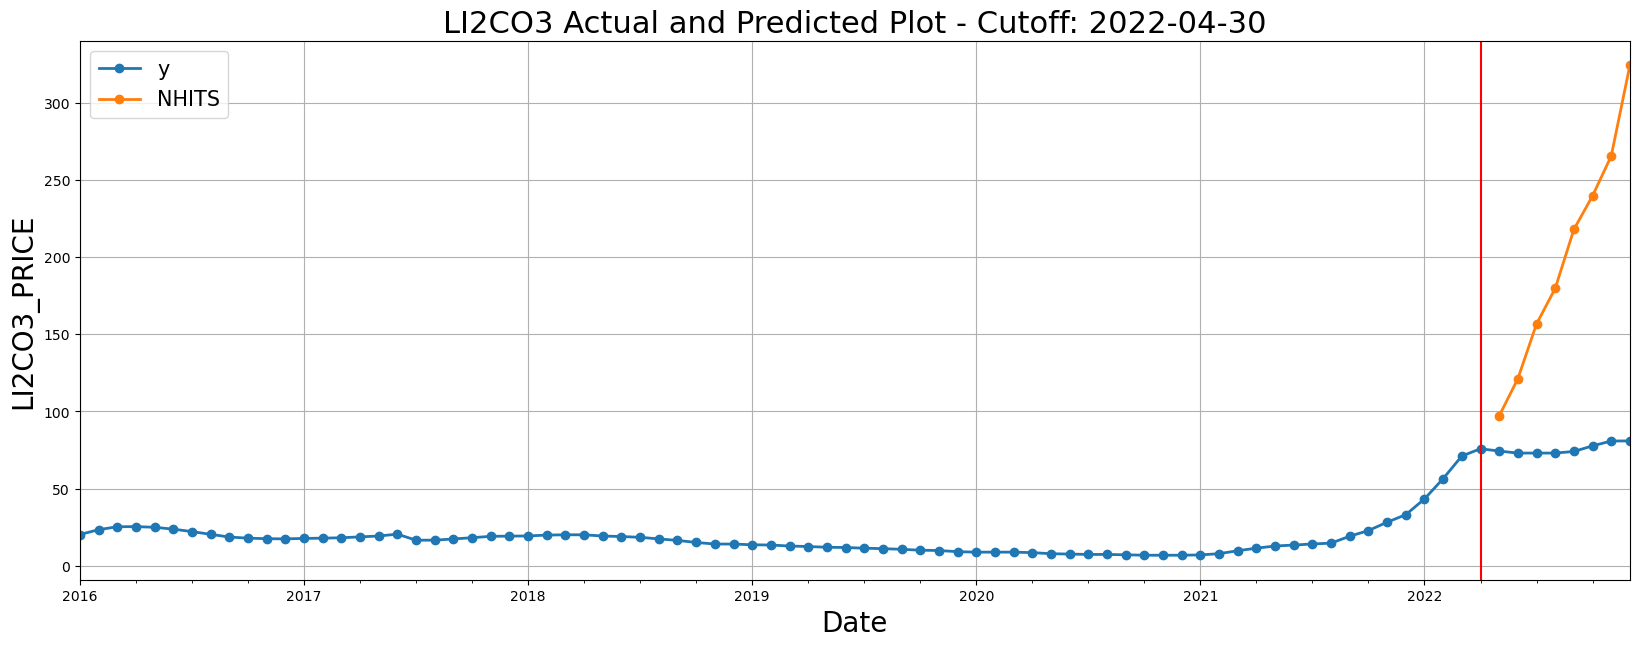

In [26]:
# Plot predictions
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
Y_hat_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])
plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')

plot_df[['y', 'NHITS']].plot(ax=ax, linewidth=2, marker='o')

plt.axvline(cutoff_date, color='red')
ax.set_title(f'LI2CO3 Actual and Predicted Plot - Cutoff: {cutoff_date}', fontsize=22)
ax.set_ylabel('LI2CO3_PRICE', fontsize=20)
ax.set_xlabel('Date', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

# fig1.savefig(f'./data/forecasting_{cutoff_date}.png', dpi=100)
fig.savefig(f'./data/forecast_plot_{cutoff_date}_wv.png')

In [27]:
plot_df[['y', 'NHITS']].to_csv(f'./data/forecast_plot_{cutoff_date}_wv.csv',index=False)